# Resumen metricas

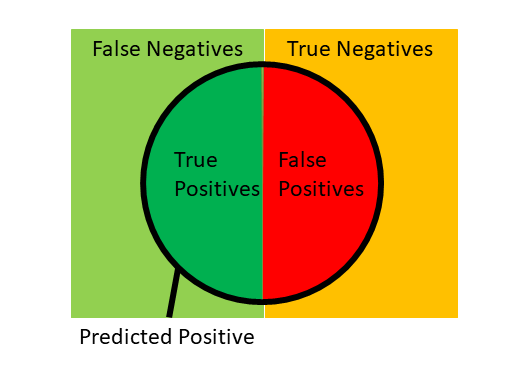
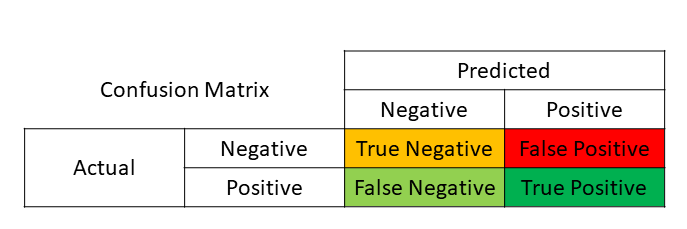
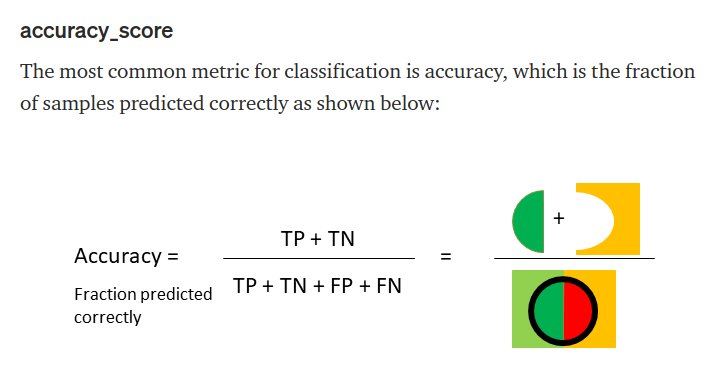
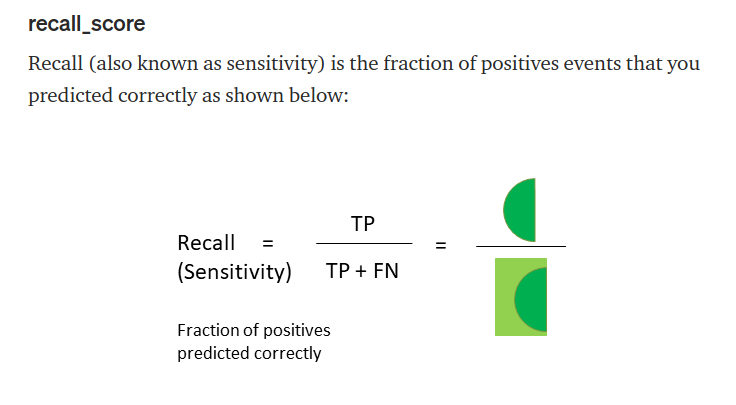
### falta el Kappa
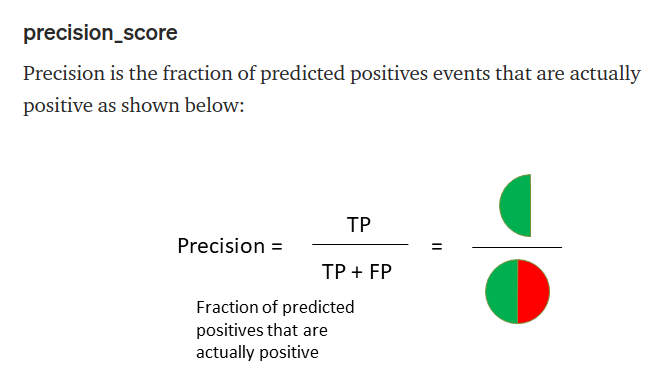
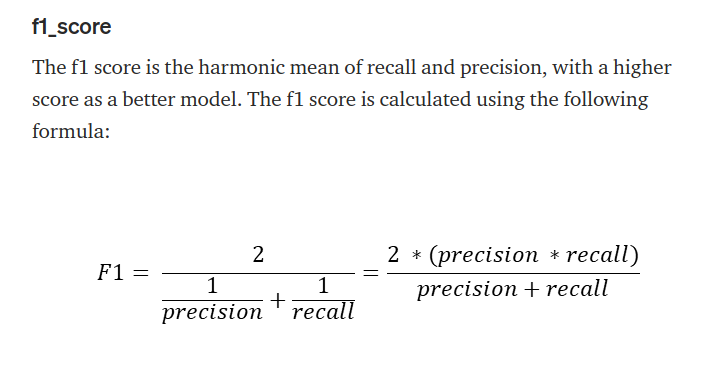
> [Fuente](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019)


In [141]:
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/akima/.virtualenvs/mn/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/akima/Documents/mn/repo/tp2
-- Configuring done
-- Generating done
-- Build files have been written to: /home/akima/

In [32]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

# Datos

In [5]:
df_train = pd.read_csv("../data/train.csv")
df_train = df_train[5000:10000] # Probando, borrar esta linea dsp

In [6]:
df_train["label"].value_counts(normalize=True)

1    0.1074
7    0.1066
3    0.1058
9    0.1034
2    0.1000
0    0.0994
4    0.0980
6    0.0974
8    0.0946
5    0.0874
Name: label, dtype: float64

# Dividir entre train y val

In [7]:
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

In [8]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


# Correr con diferentes alpha y k

In [83]:
alpha_step = 5
alpha_max = 71

k_max = 101
k_step = 10

X_train_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)

In [84]:
datos = []

for alpha in range(1, alpha_max+1, alpha_step):
    for k in range(1, k_max+1, k_step):
        X_train_pca, X_val_pca = X_train_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_val_pca)

        acc = accuracy_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred, average = 'weighted')
        precision = precision_score(y_val, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average = 'weighted')

        datos.append({'alpha': alpha, 'k':k, 'accuracy':acc, 'recall':recall, 'precision':precision, 'kappa':kappa, 'f1':f1})

datosDF = pd.DataFrame(datos)

# Resultados

In [134]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred) # ejemplo para los ultimos y_val, y_pred

array([[ 89,   0,   0,   0,   0,   0,   2,   0,   0,   1],
       [  0, 102,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,  12,  77,   4,   1,   0,   1,   4,   4,   1],
       [  1,   4,   1,  98,   0,   0,   0,   0,   3,   2],
       [  0,   9,   0,   0,  61,   0,   4,   0,   0,  13],
       [  0,   8,   0,   7,   1,  70,   1,   0,   1,   4],
       [  0,   2,   0,   0,   0,   1, 107,   0,   1,   0],
       [  0,  12,   0,   0,   0,   0,   0,  88,   0,   4],
       [  1,   8,   0,   5,   0,   5,   4,   0,  75,   3],
       [  2,   2,   0,   1,   1,   0,   0,   2,   0,  86]])

In [86]:
datosIndexed =  datosDF.set_index(['k', 'alpha']).unstack(level=0)

In [87]:
datosIndexed['accuracy']

k,1,11,21,31,41,51,61,71,81,91,101
alpha,,,,,,,,,,,
1,0.240,0.271,0.274,0.286,0.290,0.290,0.278,0.294,0.305,0.301,0.302
6,0.756,0.797,0.799,0.806,0.791,0.793,0.788,0.783,0.774,0.779,0.776
11,0.891,0.889,0.880,0.883,0.874,0.869,0.857,0.852,0.849,0.849,0.842
16,0.928,0.927,0.917,0.910,0.906,0.899,0.893,0.889,0.885,0.877,0.878
21,0.935,0.925,0.929,0.921,0.916,0.908,0.907,0.906,0.899,0.900,0.894
26,0.933,0.935,0.928,0.914,0.911,0.909,0.905,0.903,0.900,0.894,0.892
31,0.935,0.935,0.929,0.921,0.917,0.913,0.908,0.899,0.892,0.885,0.882
36,0.938,0.936,0.926,0.917,0.915,0.910,0.899,0.902,0.898,0.888,0.877
41,0.940,0.936,0.927,0.920,0.915,0.900,0.904,0.898,0.894,0.884,0.874


In [133]:
datosIndexed.idxmax()
# datosIndexed['accuracy'].max().max()
datosIndexed.loc[1]['accuracy'][11]

0.271

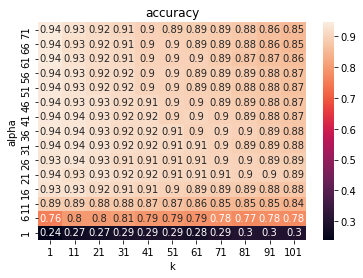

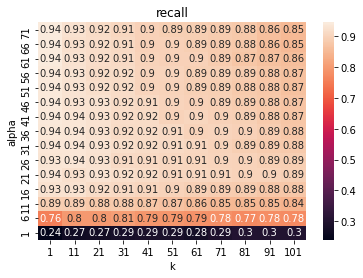

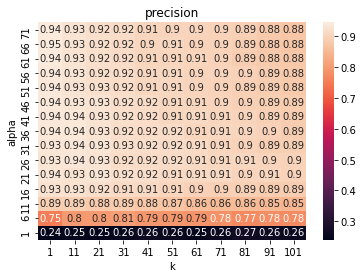

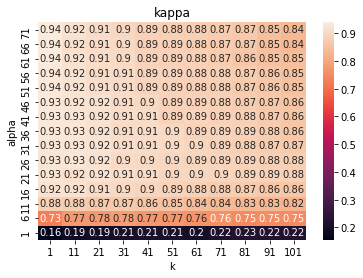

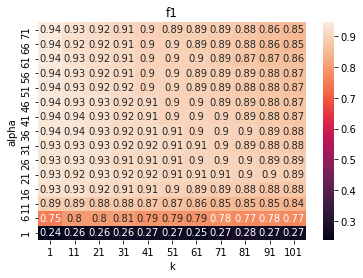

In [88]:
for metric in ['accuracy', 'recall', 'precision', 'kappa', 'f1']:
    sns.heatmap(datosIndexed[metric], annot = True).invert_yaxis()
    plt.title(metric)
    plt.show()

# Variando tamaño de entrenamiento

In [163]:
alpha = 70
k = 6

pca= metnum.PCA(alpha)
clf = metnum.KNNClassifier(k)

datos = []
for portion in np.arange(0.1, 1, 0.1):
    limit = int(portion * X.shape[0]) 

    X_train, y_train = X[:limit], y[:limit]
    X_val, y_val = X[limit:], y[limit:]

    print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")
    
    pca.fit(train)
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)

    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_val_pca)

    acc = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average = 'weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average = 'weighted')

    datos.append({'portion': round(portion, 2), 'accuracy':acc, 'recall':recall, 'precision':precision, 'kappa':kappa, 'f1':f1})
            
datosExp2DF = pd.DataFrame(datos)

Ahora tengo 500 instancias de entrenamiento y 4500 de validación
Ahora tengo 1000 instancias de entrenamiento y 4000 de validación
Ahora tengo 1500 instancias de entrenamiento y 3500 de validación
Ahora tengo 2000 instancias de entrenamiento y 3000 de validación
Ahora tengo 2500 instancias de entrenamiento y 2500 de validación
Ahora tengo 3000 instancias de entrenamiento y 2000 de validación
Ahora tengo 3500 instancias de entrenamiento y 1500 de validación
Ahora tengo 4000 instancias de entrenamiento y 1000 de validación
Ahora tengo 4500 instancias de entrenamiento y 500 de validación


In [166]:
datosExp2DFIndex = datosExp2DF.set_index('portion')
datosExp2DFIndex

,accuracy,recall,precision,kappa,f1
portion,,,,,
0.1,0.848667,0.848667,0.860116,0.831668,0.848571
0.2,0.886000,0.886000,0.892697,0.873229,0.885994
0.3,0.899143,0.899143,0.906344,0.887865,0.899197
0.4,0.910000,0.910000,0.915742,0.899964,0.910180
0.5,0.921600,0.921600,0.925126,0.912860,0.921664
0.6,0.930500,0.930500,0.932925,0.922754,0.930356
0.7,0.931333,0.931333,0.933343,0.923670,0.931002
0.8,0.932000,0.932000,0.934460,0.924383,0.931756
0.9,0.922000,0.922000,0.928013,0.913184,0.921756
